In [1]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDelta, Trace_ELBO

from asteroglitch.model import GlitchModel
from asteroglitch.model import Prior, Observed, Posterior

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

frac_age  delta_nu_fit      nu_max  nu_0_1     nu_0_2     nu_0_3  \
0  0.000016     11.884045  150.680452     0.0  34.481794  49.329712   
1  0.000017     12.140476  154.893200     0.0  35.203007  50.376320   
2  0.000017     12.343045  158.238356     0.0  35.772049  51.202159   
3  0.000018     12.503403  160.898485     0.0  36.222266  51.855582   
4  0.000018     12.633487  163.061612     0.0  36.587368  52.385499   

      nu_0_4     nu_0_5     nu_0_6      nu_0_7  ...     nu_0_32     nu_0_33  \
0  63.195077  75.913367  87.630758   99.483102  ...  392.064627  403.710370   
1  64.548471  77.583389  89.569246  101.679667  ...  400.620086  412.538305   
2  65.616199  78.900744  91.100159  103.413323  ...  407.368711  419.505074   
3  66.460893  79.942765  92.312228  104.785371  ...  412.708426  425.019262   
4  67.145867  80.787635  93.295718  105.898357  ...  417.037759  429.491253   

      nu_0_34     nu_0_35     nu_0_36     nu_0_37     nu_0_38     nu_0_39  \
0  415.297909  426.924218  438.655667  450.550178  462.546781  474.658899   
1  424.386957  436.252351  448.212638  460.326691  472.558635  484.919720   
2  431.563921  443.619056  455.762984  468.048949  480.469626  493.018551   
3  437.245702  449.452226  461.742276  474.164224  486.734715  499.427290   
4  441.854064  454.184875  466.594022  479.127384  491.819429  504.626946   

      nu_0_40  surface_he4  
0  486.825847     0.239966  
1  497.325734     0.239967  
2  505.616340     0.239968  
3  512.179364     0.239969  
4  517.505773     0.239969  

[5 rows x 44 columns]

In [3]:
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


In [6]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [7]:
nu_obs = np.random.normal(nu, nu_err)

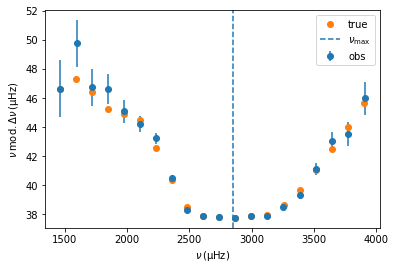

In [8]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [9]:
epsilon = [1.3, 0.2]
alpha = [np.log(0.001), 1.0]
delta_nu = [delta_nu_fit, 1.0]
nu_max = [nu_max_sca, 0.05*nu_max_sca]

In [10]:
num_orders = 20

In [11]:
prior = Prior(delta_nu, nu_max, epsilon, alpha, num_orders=num_orders)

In [12]:
init_strategy = lambda site=None: init.init_to_median(site=site, num_samples=1000)

In [13]:
num_warmup, num_samples, num_chains = 2000, 2000, 2

rng_key = random.PRNGKey(0)

kernel = NUTS(prior.model, target_accept_prob=0.99, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [14]:
mcmc.run(rng_key)
mcmc.print_summary()

/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:979: UserWarning: Continuous inference poorly handles circular sample site 'phi_he'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_he': CircularReparam()}).
  warnings.warn(msg, UserWarning)
/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:979: UserWarning: Continuous inference poorly handles circular sample site 'phi_cz'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_cz': CircularReparam()}).
  warnings.warn(msg, UserWarning)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.00      0.00      0.00      0.00      0.00   3831.27      1.00
         b0      0.03      0.04      0.02      0.00      0.07   3320.44      1.00
         b1      0.00      0.00      0.00      0.00      0.00   3213.10      1.00
         c0 6666796.32 7755392.64 4118454.46 204953.57 14876834.99   2896.23      1.00
   delta_nu    128.69      0.99    128.70    127.12    130.32   3536.01      1.00
  delta_tau      0.00      0.00      0.00      0.00      0.00   2689.85      1.00
    epsilon      1.30      0.20      1.30      0.97      1.64   3809.76      1.00
     nu_err      0.08      0.06      0.07      0.00      0.16   3020.69      1.00
     nu_max   2853.32    147.40   2851.85   2603.32   3081.54   4250.18      1.00
     phi_cz     -0.01      1.72     -0.03     -3.12      2.39   4551.31      1.00
     phi_he      0.01      1.77      0.03     -3.04      2.55   4764.53      1.00
     tau_h

In [15]:
trace_prior = az.from_dict(
    posterior=mcmc.get_samples(group_by_chain=True),
    sample_stats=mcmc.get_extra_fields(group_by_chain=True),
)

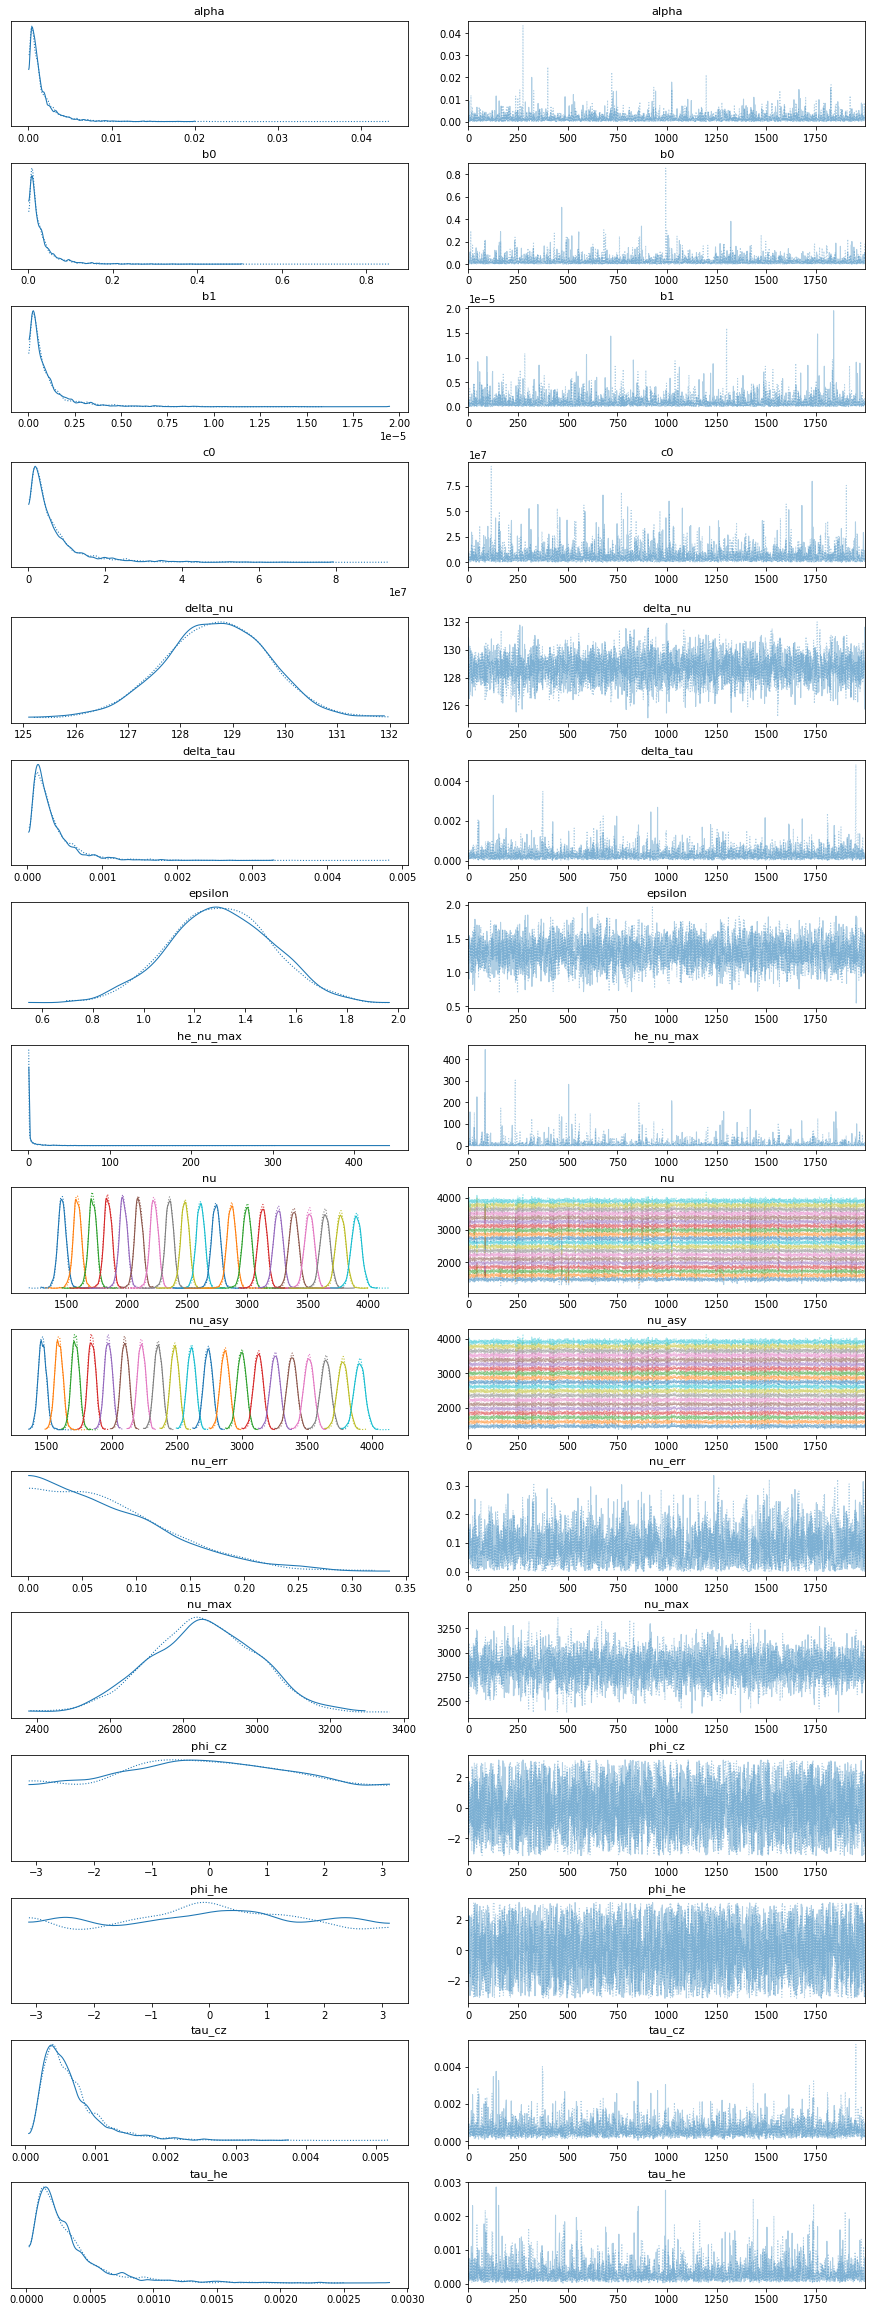

In [16]:
az.plot_trace(trace_prior);

In [13]:
observed = Observed(nu_obs, nu_err=nu_err)
# observed = Observed(nu)

In [14]:
posterior = Posterior(prior, observed)

In [15]:
# model = jax.pmap(posterior.model)
model = posterior.model

In [71]:
optimizer = Adam(step_size=0.005)
loss = Trace_ELBO(1000)

guide = AutoDelta(model, init_loc_fn=init_strategy)
svi = SVI(model, guide, optimizer, loss)

In [72]:
svi_result = svi.run(random.PRNGKey(0), 10000)

100%|██████████| 10000/10000 [00:04<00:00, 2170.34it/s, init loss: 23364.1300, avg. loss [9501-10000]: -23.5833]


In [22]:
svi_result.params

{'alpha_auto_loc': DeviceArray(0.00180003, dtype=float64),
 'b0_auto_loc': DeviceArray(0.02614218, dtype=float64),
 'b1_auto_loc': DeviceArray(6.70877479e-07, dtype=float64),
 'c0_auto_loc': DeviceArray(3422385.65524648, dtype=float64),
 'delta_nu_auto_loc': DeviceArray(128.7725651, dtype=float64),
 'delta_tau_auto_loc': DeviceArray(0.00051184, dtype=float64),
 'epsilon_auto_loc': DeviceArray(1.27911849, dtype=float64),
 'nu_err_auto_loc': DeviceArray(0.12116285, dtype=float64),
 'nu_max_auto_loc': DeviceArray(2850.16407222, dtype=float64),
 'phi_cz_unwrapped_auto_loc': DeviceArray(-6.25736471, dtype=float64),
 'phi_he_unwrapped_auto_loc': DeviceArray(1.45946228, dtype=float64),
 'tau_he_auto_loc': DeviceArray(0.00022856, dtype=float64)}

In [23]:
num_warmup, num_samples, num_chains = 2000, 2000, 5

rng_key = random.PRNGKey(0)

kernel = NUTS(model, target_accept_prob=0.99, init_strategy=init_strategy, 
              dense_mass=True
             )
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains,
#            progress_bar=False
           )

In [24]:
init_params = {k[:k.find('_auto_loc')]: v for k, v in svi_result.params.items()}

In [25]:
init_params_batched = jax.tree_map(lambda x: jnp.broadcast_to(x, (num_chains,)), init_params)

In [26]:
# %%time
mcmc.run(
    rng_key, 
    init_params=init_params_batched
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [27]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.00      0.00      0.00      0.00      0.00    209.02      1.02
                b0      0.04      0.02      0.03      0.02      0.06   1516.39      1.00
                b1      0.00      0.00      0.00      0.00      0.00    794.26      1.01
                c0 3487153.37 348690.53 3497337.29 2931067.42 4059471.20   4739.50      1.00
          delta_nu    128.81      0.28    128.80    128.36    129.23    565.66      1.01
         delta_tau      0.00      0.00      0.00      0.00      0.00    915.19      1.01
           epsilon      1.27      0.05      1.27      1.19      1.35    495.65      1.01
            nu_err      0.15      0.03      0.14      0.10      0.19   2907.58      1.00
            nu_max   2843.54    134.27   2843.19   2622.13   3059.82   3486.75      1.00
  phi_cz_unwrapped     -3.48      5.04     -5.80     -6.92      6.80      2.53      9.76
  phi_he_unwrapp

In [28]:
group_by_chain = True
samples = mcmc.get_samples(group_by_chain=group_by_chain)
sample_stats = mcmc.get_extra_fields(group_by_chain=group_by_chain)

In [29]:
trace = az.from_dict(posterior=samples, sample_stats=sample_stats)

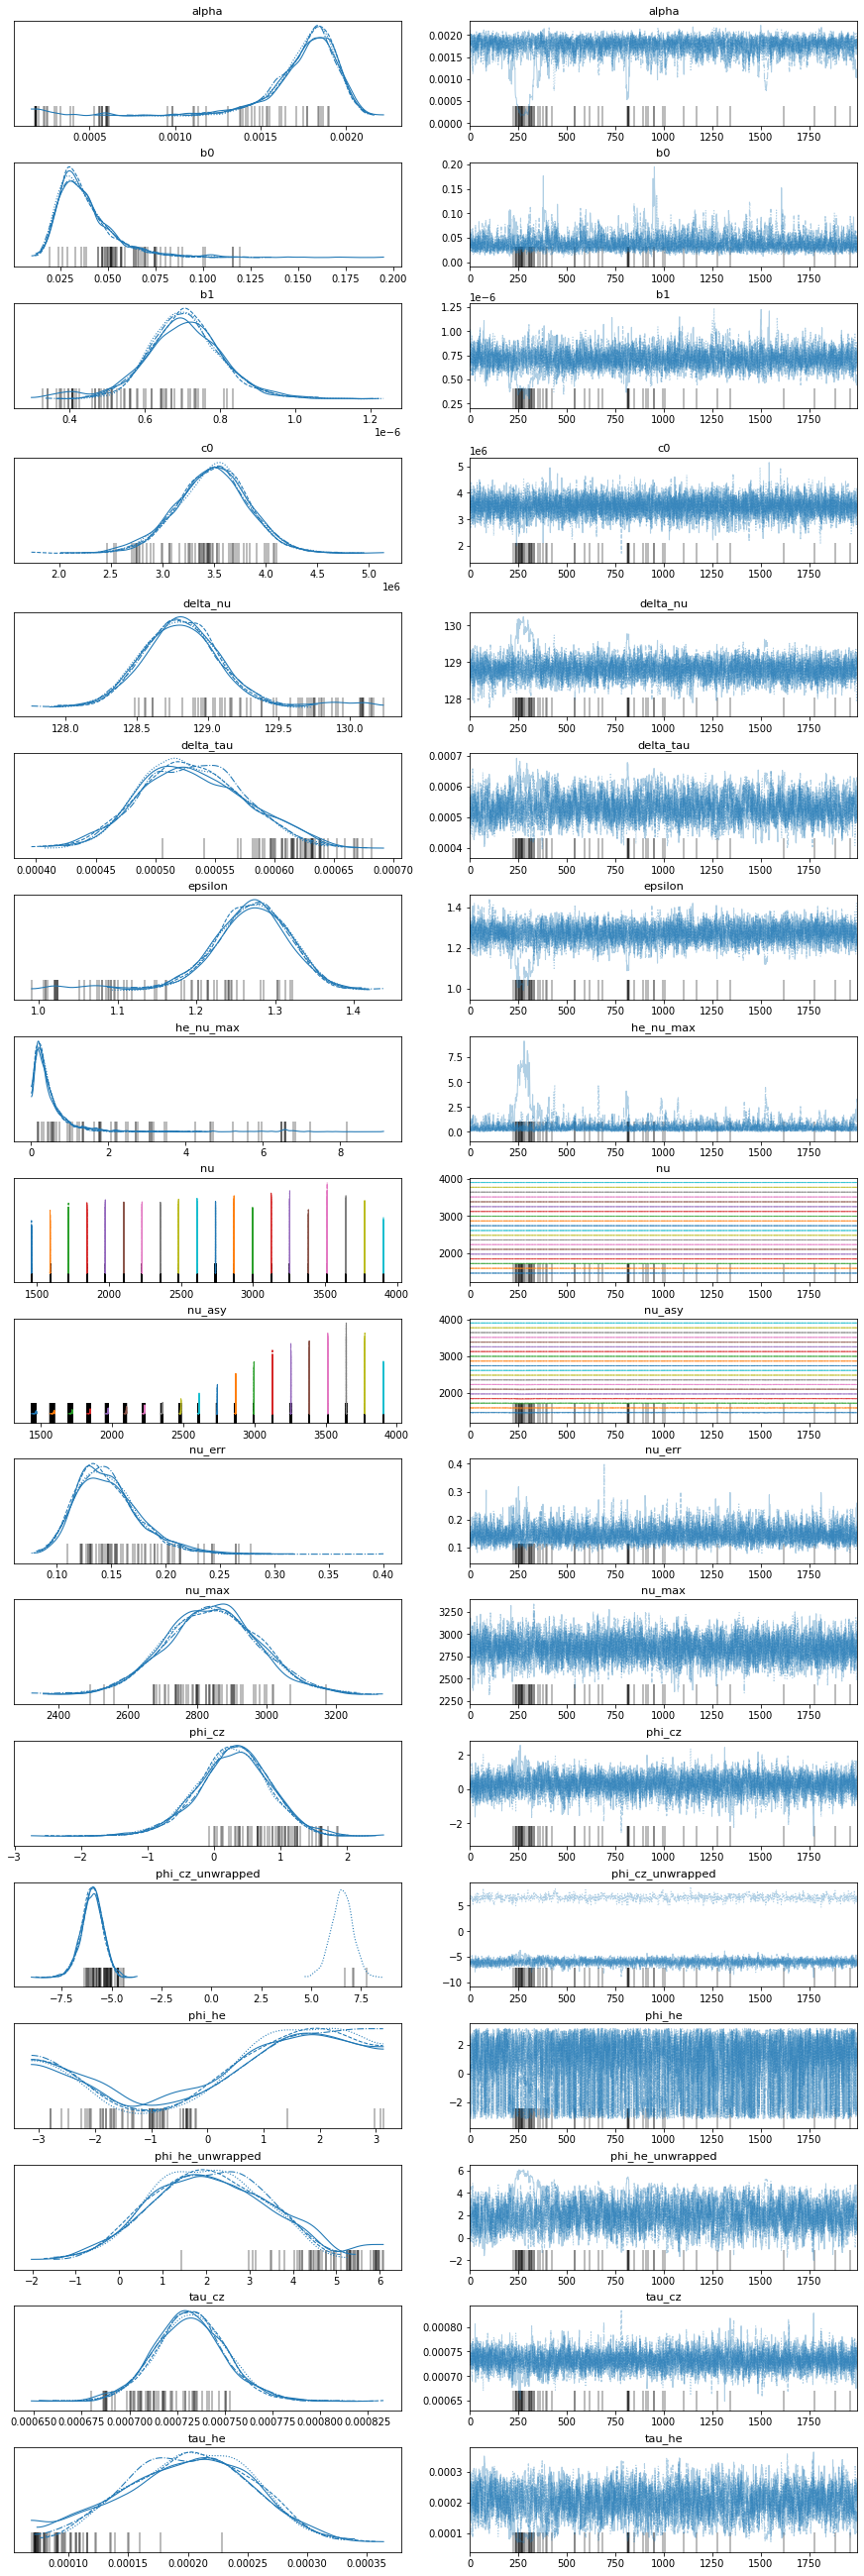

In [30]:
az.plot_trace(trace);

In [11]:
glitch = GlitchModel(delta_nu, nu_max, nu=nu_obs, nu_err=nu_err)

/Users/ajl573/Repos/alexlyttle/helium-glitch-fitter/asteroglitch/model.py:339: UserWarning: Neither argument 'n' nor 'num_orders' passed, inferring num_orders = 20 from final dimension of 'nu'.
  warnings.warn("Neither argument 'n' nor 'num_orders' passed, " +


In [38]:
model = numpyro.handlers.reparam(config={
    'phi_he': numpyro.infer.reparam.CircularReparam(),
    'phi_cz': numpyro.infer.reparam.CircularReparam()
})(model)

In [16]:
guide = numpyro.infer.autoguide.AutoDiagonalNormal(model, init_loc_fn=init_strategy)
optim = Adam(step_size=1e-3)
# loss = Trace_ELBO()
loss = numpyro.infer.Trace_ELBO()
svi = SVI(model, guide, optim, loss)

In [17]:
rng_key = random.PRNGKey(0)

In [18]:
svi_result = svi.run(rng_key, 50000)

100%|██████████| 50000/50000 [00:13<00:00, 3680.82it/s, init loss: 41466.1464, avg. loss [47501-50000]: 49.0870] 


In [19]:
svi_result.params

{'auto_loc': DeviceArray([-6.21594715e+00, -4.11298367e+00, -1.41851564e+01,
               1.36777054e+01,  1.28649155e+02, -8.30539140e+00,
               1.30158023e+00, -1.28983971e+00,  2.85577893e+03,
              -9.81178941e-02, -1.27755741e+00, -7.98093945e+00],            dtype=float64),
 'auto_scale': DeviceArray([3.79385215e-02, 1.64769405e-01, 6.06723243e-02,
              5.07808266e-01, 3.95213967e-03, 7.41488139e-01,
              6.66734804e-04, 1.67430392e-01, 1.33504136e+01,
              2.18783710e+01, 1.66160358e-01, 1.97393141e-02],            dtype=float64)}

In [22]:
neutra = numpyro.infer.reparam.NeuTraReparam(guide, svi_result.params)

In [23]:
svi_result.params

{'auto_loc': DeviceArray([-6.18013185e+00, -4.13540628e+00, -1.42520030e+01,
               1.47744939e+01,  1.28704484e+02, -8.16509464e+00,
               1.29208572e+00, -1.73775039e+00,  2.85163819e+03,
              -1.98232778e+00, -1.29696731e+00, -7.97124665e+00],            dtype=float64),
 'auto_scale': DeviceArray([3.39071892e-02, 1.27127131e-01, 4.44333870e-02,
              2.36924193e-01, 2.77982678e-03, 2.50236426e-02,
              4.70642300e-04, 2.29557438e-01, 1.08059457e+01,
              3.18739066e-01, 1.21730074e-01, 1.29443082e-02],            dtype=float64)}

In [35]:
reparam_model = numpyro.handlers.reparam(
        config={
            "phi_he": numpyro.infer.reparam.CircularReparam(),
            "phi_cz": numpyro.infer.reparam.CircularReparam(),
        }
    )(neutra.reparam(model)
)

In [36]:
nuts = NUTS(reparam_model, target_accept_prob=0.99, init_strategy=init_strategy)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4)

In [37]:
mcmc.run(rng_key)

KeyError: 'epsilon'

In [27]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
 auto_shared_latent[0]     -3.11      5.65     -1.84    -11.29      4.42    219.42      1.00
 auto_shared_latent[1]     -2.76      5.58     -2.76    -11.42      7.14    337.10      1.00
 auto_shared_latent[2]     -6.15      8.52     -5.03    -19.28      7.45    243.50      1.00
 auto_shared_latent[3]      0.98      1.10      1.03     -0.67      2.79    512.64      1.00
 auto_shared_latent[4]     16.66     96.03     18.92   -133.32    183.57    365.73      1.00
 auto_shared_latent[5]      2.89      9.27      3.43    -10.37     17.65    218.71      1.01
 auto_shared_latent[6]    -16.69     97.23    -16.03   -181.16    140.21    375.27      1.00
 auto_shared_latent[7]     -2.67      2.13     -2.55     -6.25      0.57    744.96      1.00
 auto_shared_latent[8]     -0.46     12.54     -0.67    -21.24     20.00    433.34      1.00
 auto_shared_latent[9]      0.73      4.43      1.32     -6.17      7

In [28]:
group_by_chain = True
samples = mcmc.get_samples(group_by_chain=group_by_chain)
sample_stats = mcmc.get_extra_fields(group_by_chain=group_by_chain)

In [29]:
trace = az.from_dict(posterior=samples, sample_stats=sample_stats)

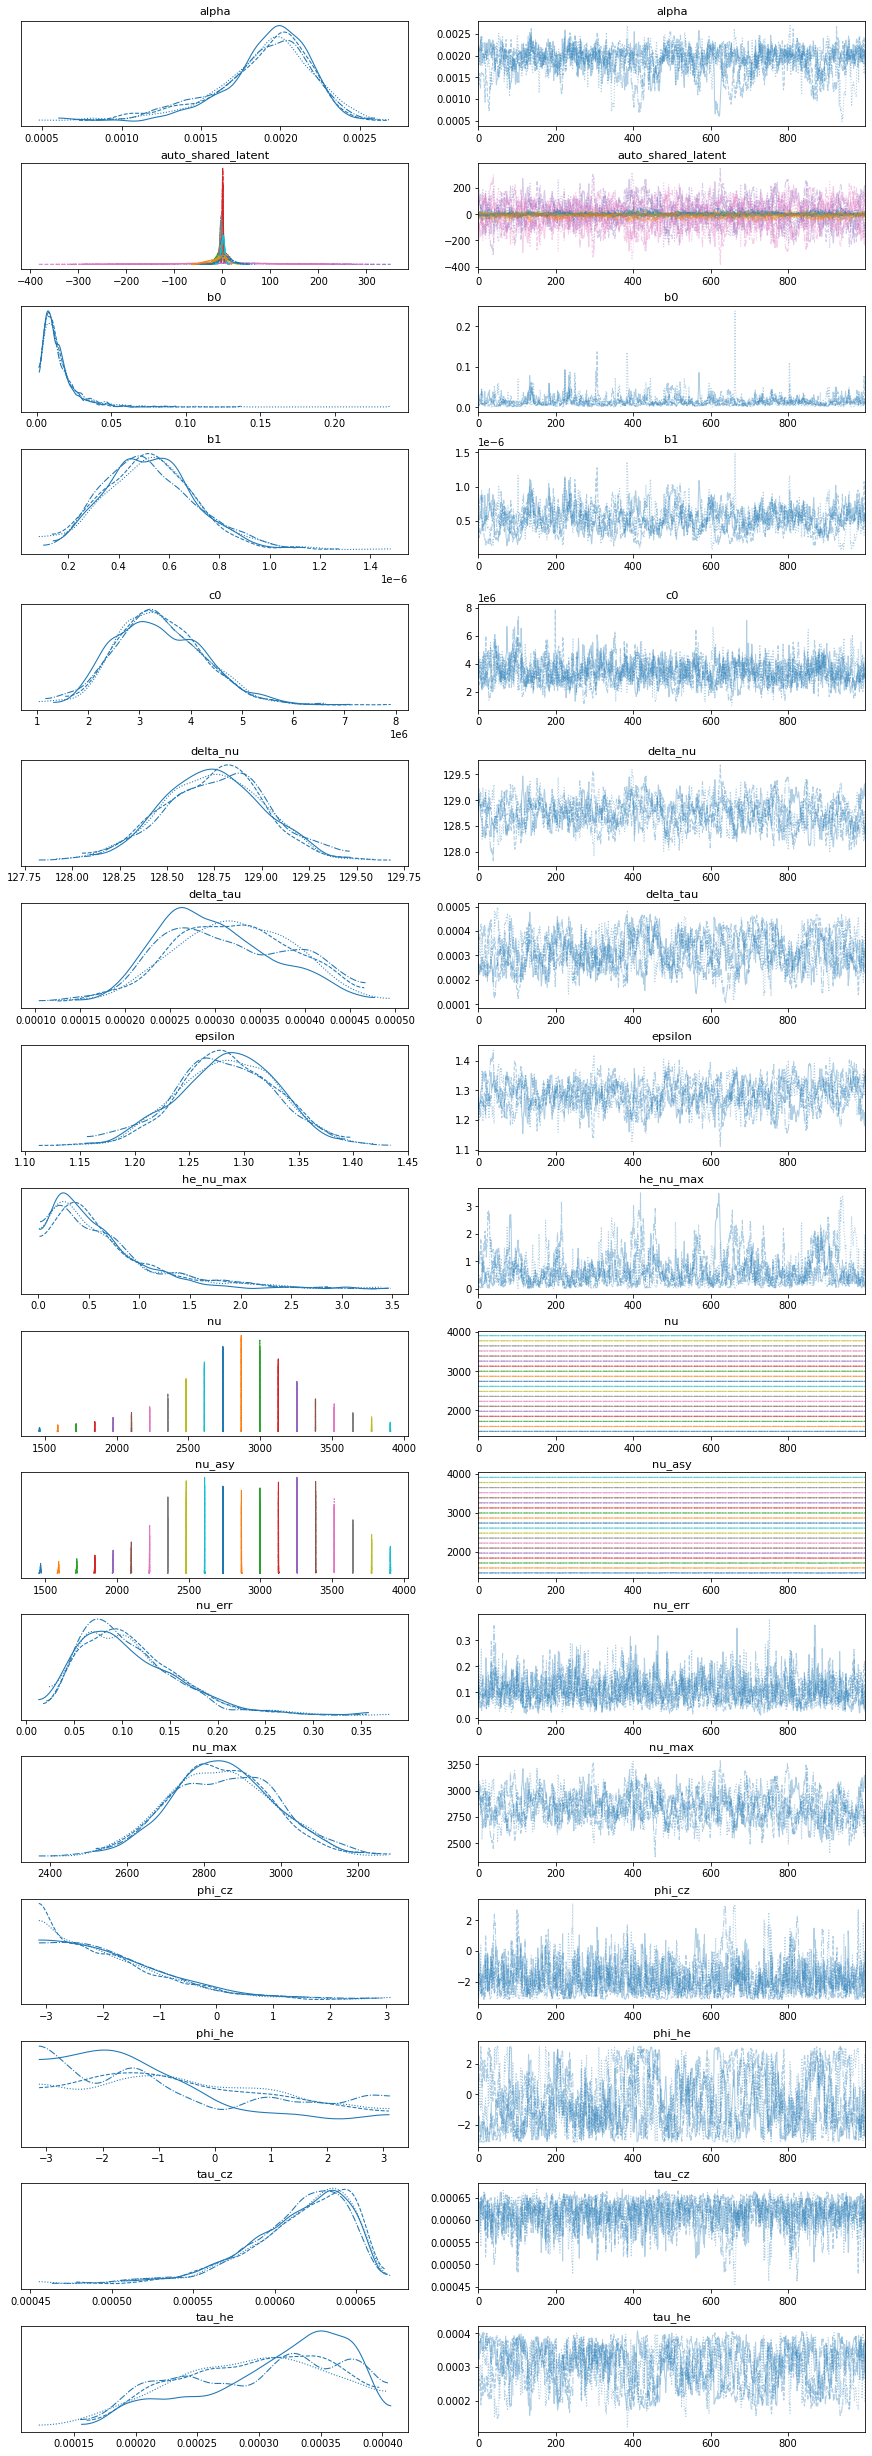

In [30]:
az.plot_trace(trace);

In [23]:
from corner import corner

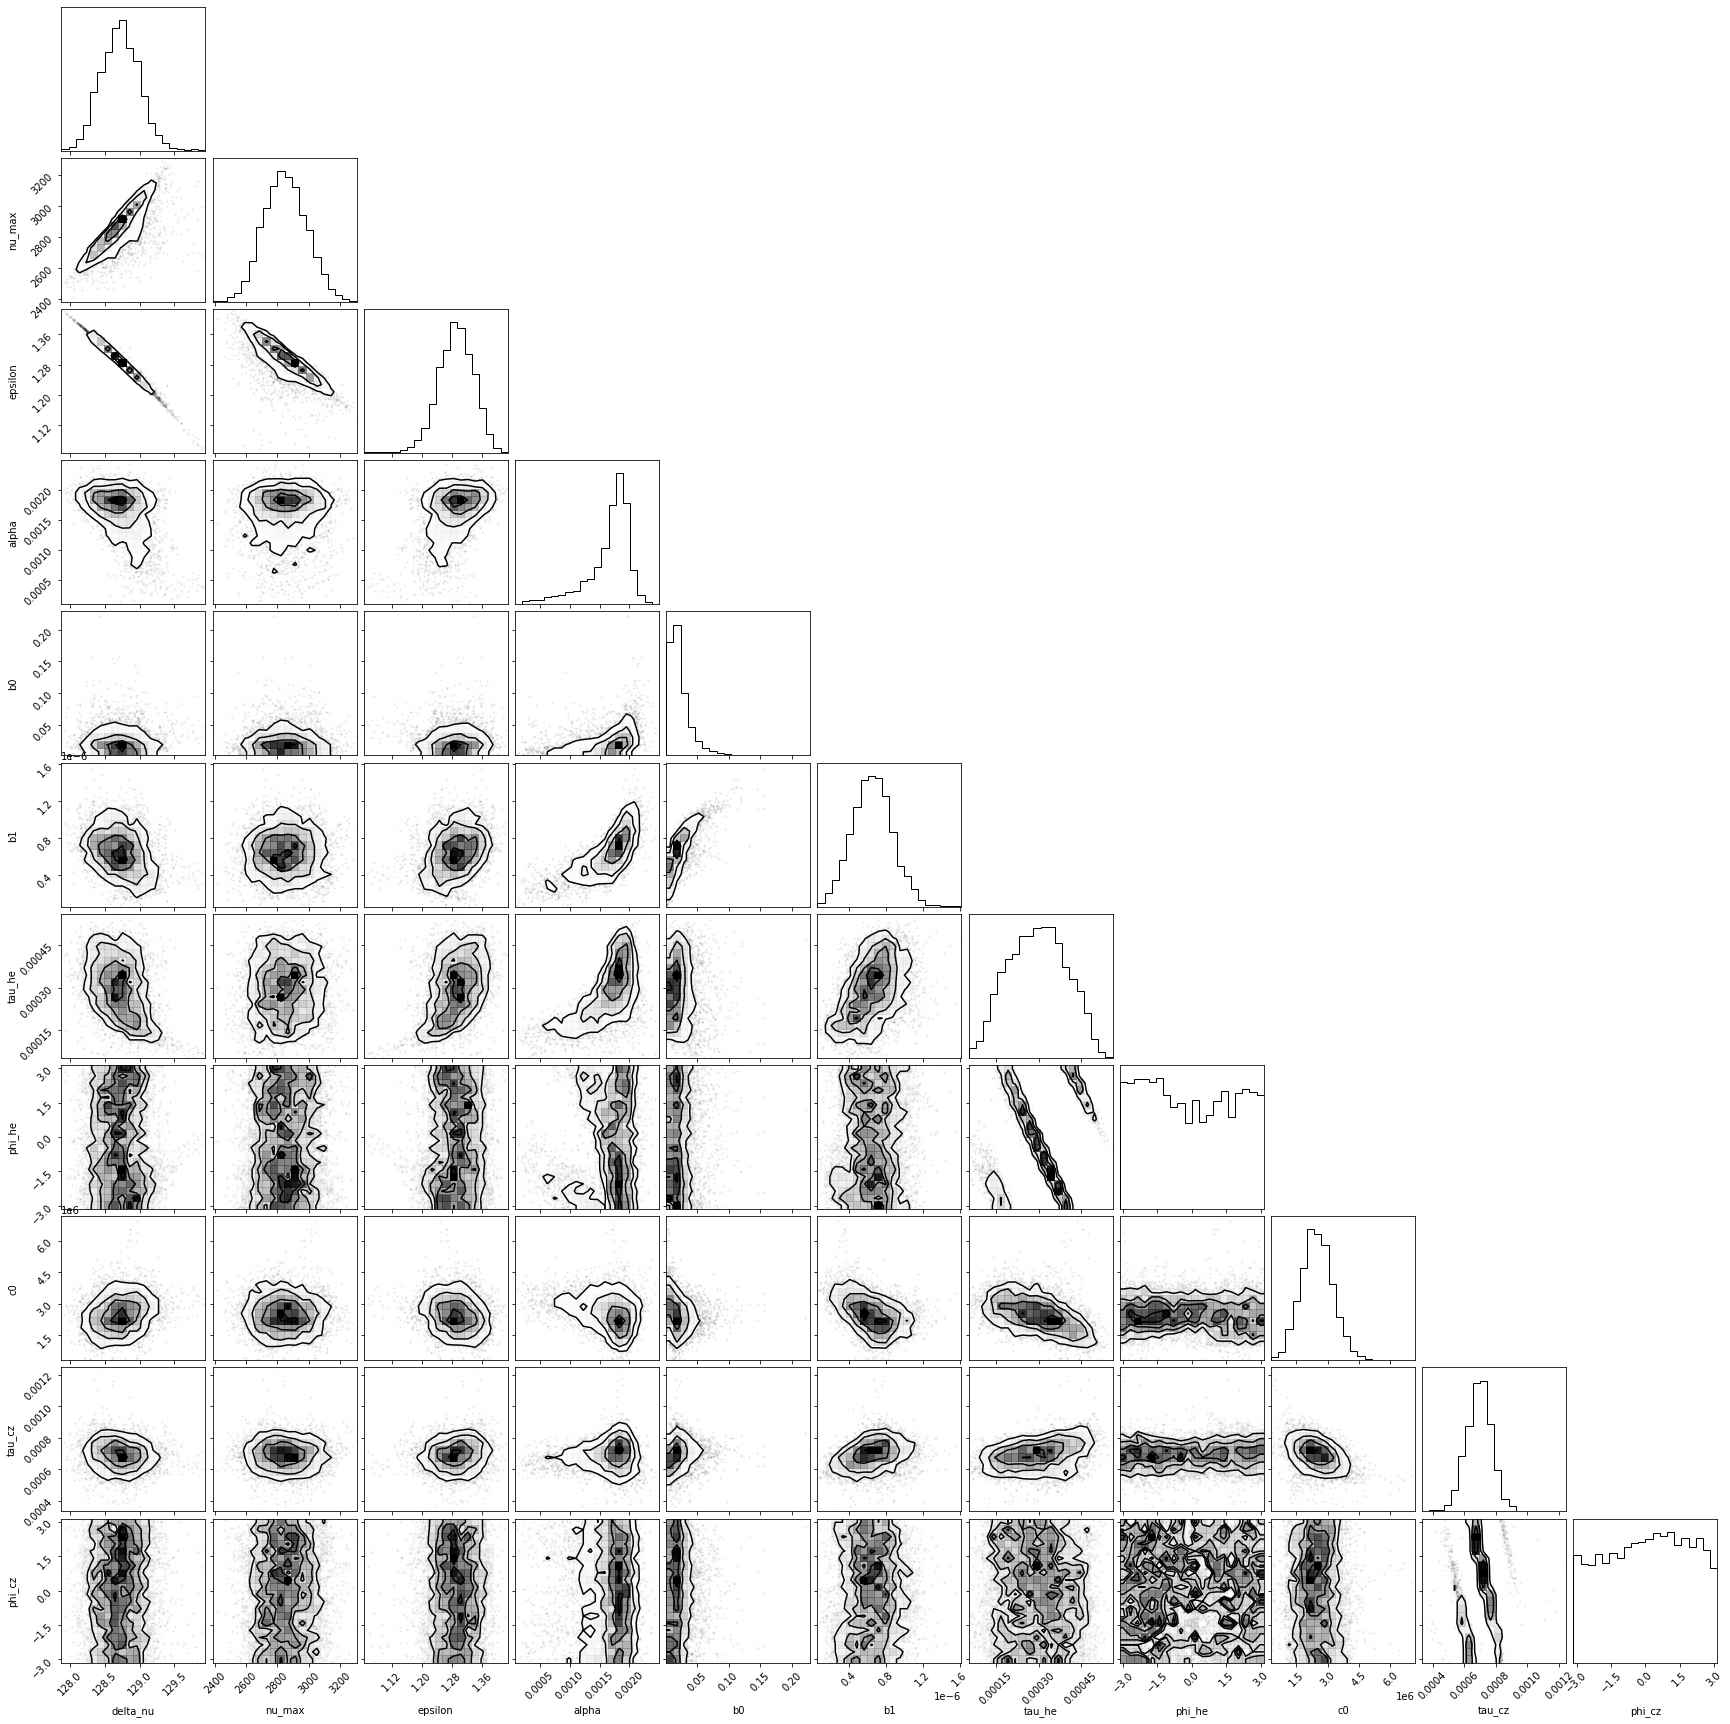

In [150]:
corner(
    trace, 
    var_names=['delta_nu', 'nu_max', 'epsilon', 'alpha', 'b0', 'b1', 'tau_he', 'phi_he', 'c0', 'tau_cz', 'phi_cz'], 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

In [42]:
prior_predictive = numpyro.infer.Predictive(model, num_samples=5000, batch_ndims=2)

In [43]:
samples = prior_predictive(random.PRNGKey(0))

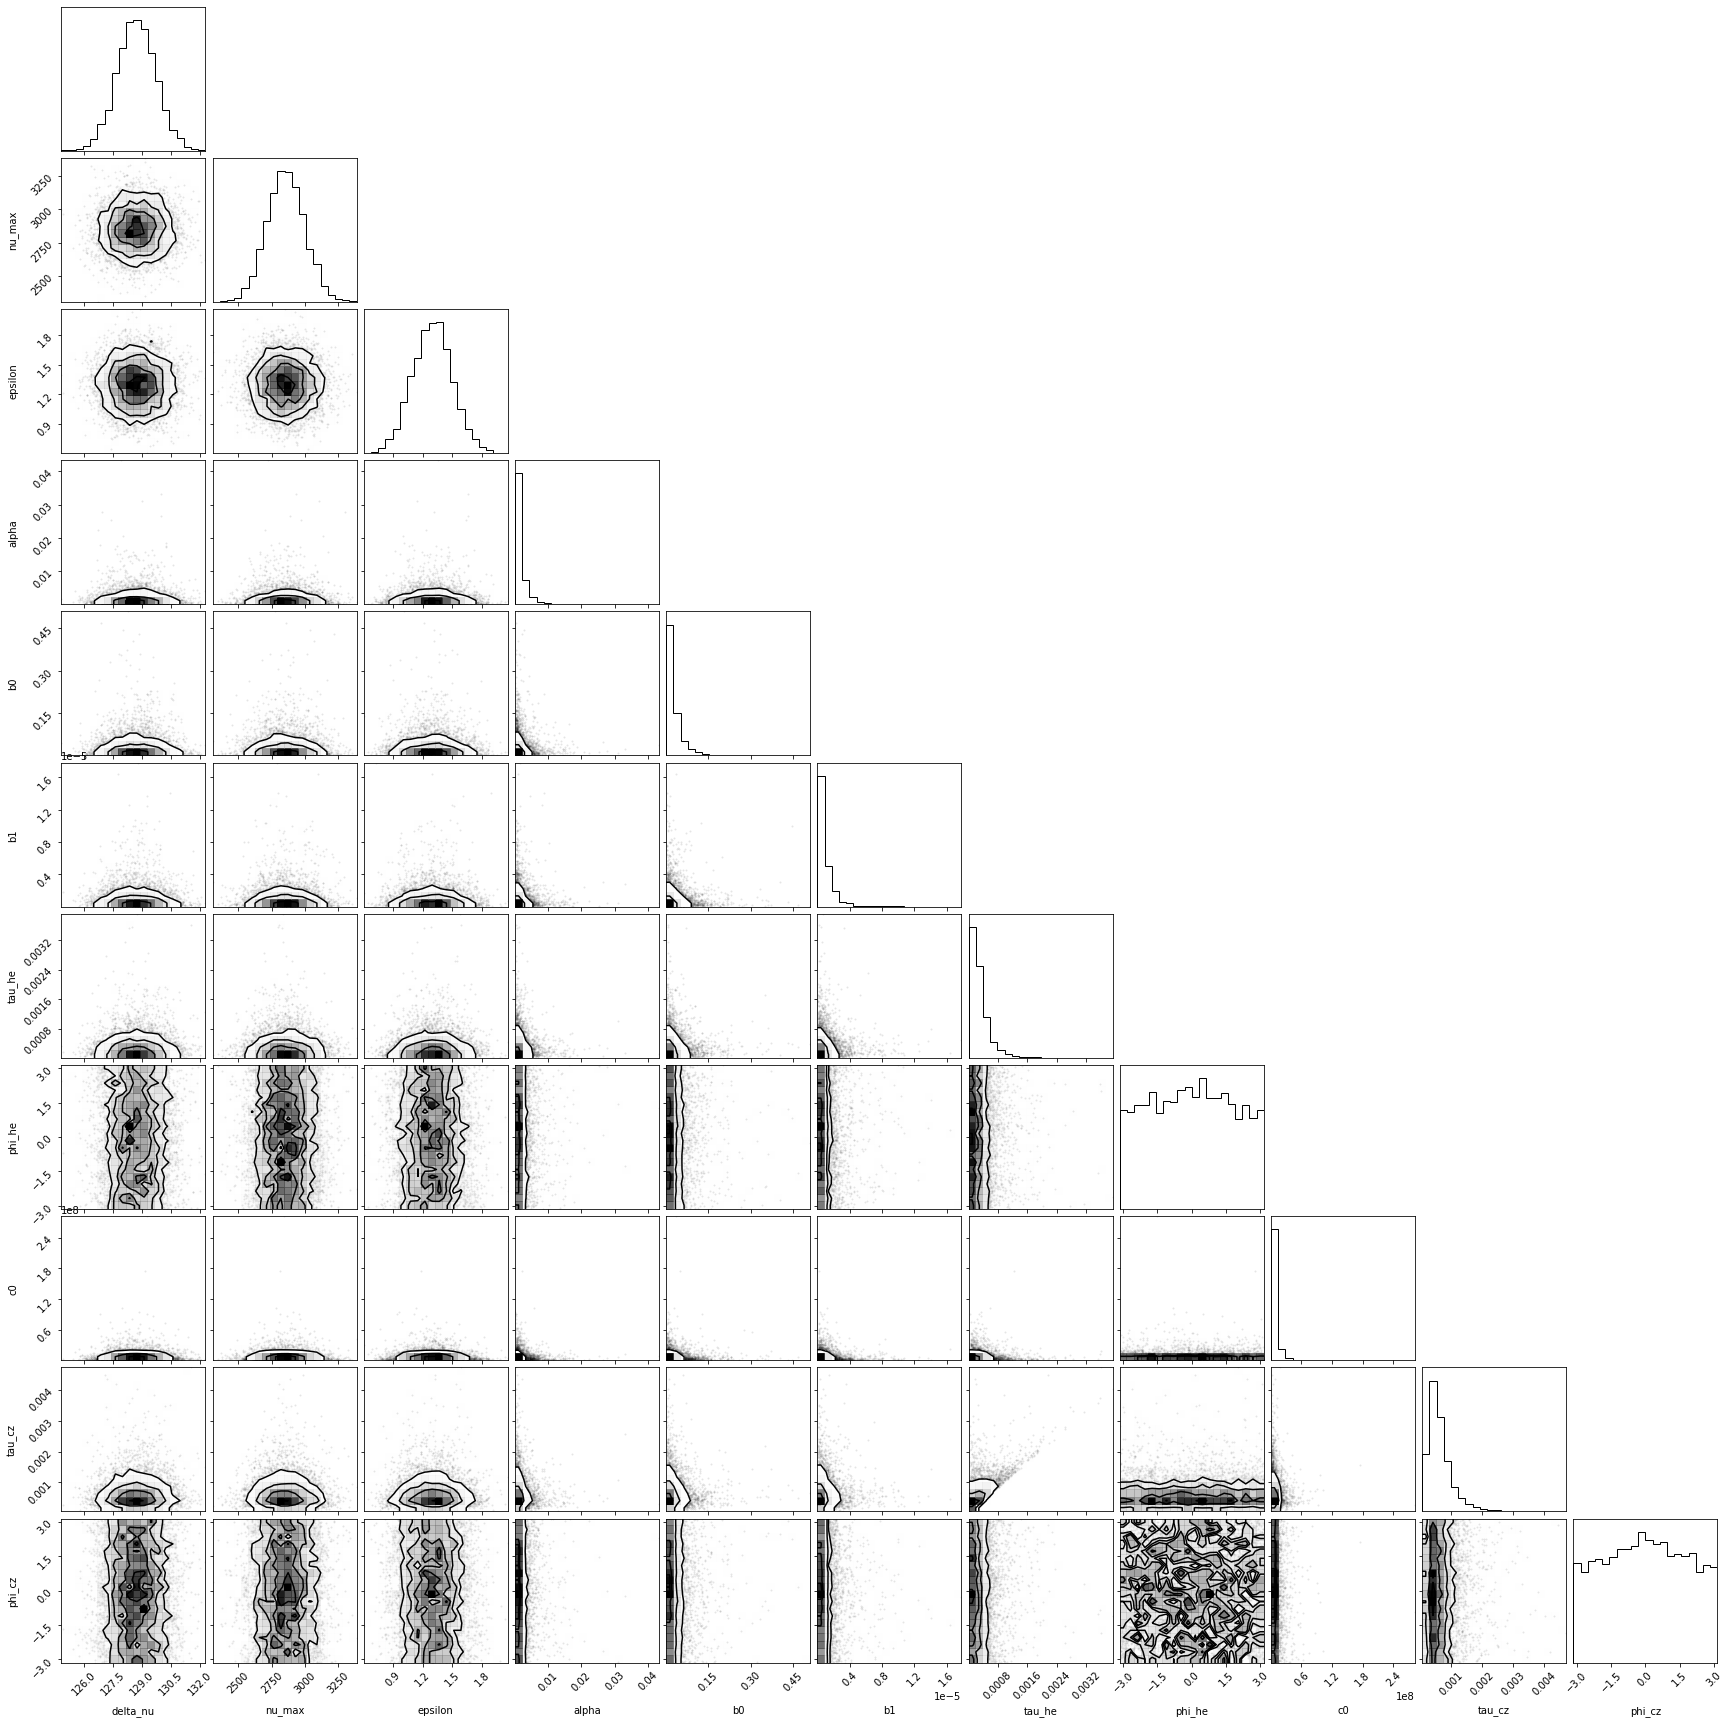

In [44]:
corner(
    samples, 
    var_names=['delta_nu', 'nu_max', 'epsilon', 'alpha', 'b0', 'b1', 'tau_he', 'phi_he', 'c0', 'tau_cz', 'phi_cz'], 
);

In [58]:
jnp.array([1., jnp.nan]).dtype

dtype('float64')

In [151]:
def combine_chains(x):
    return jnp.reshape(x, (x.shape[0]*x.shape[1], *x.shape[2:]))

In [154]:
n = prior.n

nu_model = combine_chains(samples['nu'])
num_modes = nu_model.shape[1]

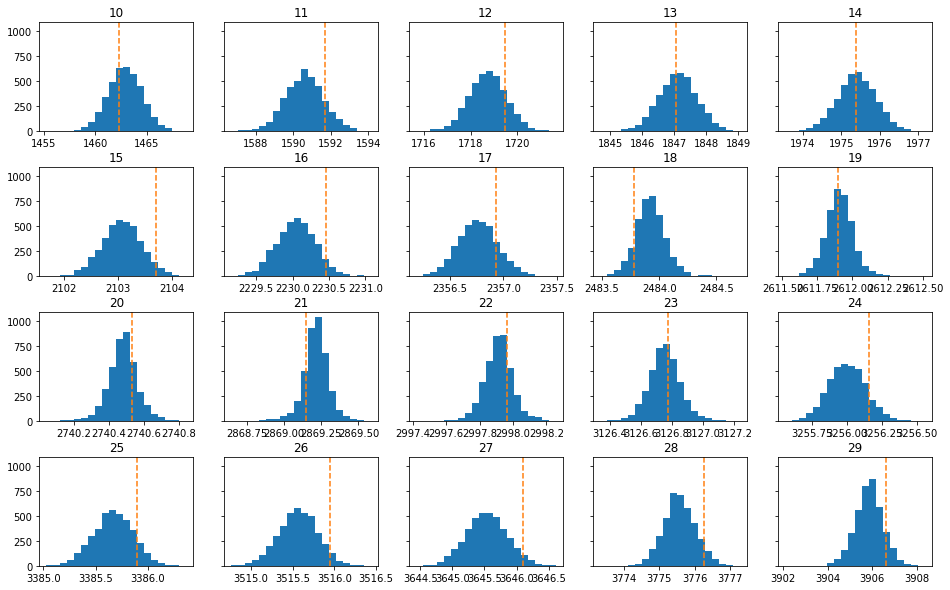

In [155]:
nrows = int(np.floor(np.sqrt(num_modes)))
ncols = int(np.ceil(num_modes/nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), sharey=True,
                        gridspec_kw={'hspace': .33})

for ax, nu_m, nu_t, _n in zip(np.ravel(axes), nu_model.T, nu, n):
    ax.hist(nu_m, bins=20, color='C0')
    ax.axvline(nu_t, color='C1', linestyle='--')
    ax.ticklabel_format(useOffset=False)
    ax.set_title(f'{_n}')